# held out disease experiment

Eval of how it performs on unseen diseases

For each study s_i 

1. Remove all sentences for study s_i  from the training  set.  
2. Fit model to training set 
3. Strip all sentence for any study which is not s_i from test set
4. Fit & predict held out study

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime, timedelta
import gensim
import negation_data


data_root_folder = 'data'
data_raw_folder = data_root_folder + '/raw'
data_processed_folder = data_root_folder + '/processed'
data_cached_folder= data_root_folder + '/cached'
datasets_folder = data_root_folder + '/datasets'
results_folder='data/results/withheld_disease_eval'

import keras.backend as K

dtype='float16'
K.set_floatx(dtype)

# default is 1e-7 which is too small for float16.  Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
K.set_epsilon(1e-4) 


# hyper params chosen when producing the datasets
embedding_dimension=300 # size of token vectors
max_document_length=300 # truncate sentences longer than this
num_token_types = 71333 # magic number, it is determined by the tokeniser used to produce the dataset eg
disease_phrase_keep_rate=1.0 # likelihood we will drop the disease phrase when training
#tokeniser=get_tokeniser('negation_detection_sentences_experiment_%s_train.txt' % experiment)
#num_token_types=len(tokeniser.word_index)

# 8=referral
# 9=primary

number_of_classes=4
window_before_diagnosis=8
window_after_diagnosis=0
dataset='test' # dev or test
model_name='bilstm'
experiment='pri_ref'

# these labels match https://hhsrvmlr1.rvc.ac.uk:8888/notebooks/fp/False%20positives%20-%20CNN%20-%20Dataset%20production.ipynb
class_labels={
    0: '1-never diagnosed',
    1: '2-prior to diagnostic window',
    2: '3-after diagnostic window',
    3: '4-during diagnostic window'}

/home/noel/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load persisted datasets
def load_word2vec_new():
    return gensim.models.KeyedVectors.load_word2vec_format('data/processed/vec_sg_20180321.txt', binary=False, unicode_errors='ignore')

def load_dataset(experiment=8,dataset='train',number_of_classes=4,window_before_diagnosis=8,window_after_diagnosis=0):
    import json
    
    x_1=np.load(datasets_folder+'/x_%s_1_exp_%s.npy' % (dataset,experiment))
    x_2=np.load(datasets_folder+'/x_%s_2_exp_%s.npy' % (dataset,experiment))
    y=np.load(datasets_folder+'/y_%s_exp_%s_classes_%s_window_before_diagnosis_%s_window_after_diagnosis_%s.npy' % 
            (dataset,experiment,number_of_classes,window_before_diagnosis,window_after_diagnosis))
    with open(datasets_folder+'/study_sentence_dictionary_%s_exp_%s.json' % (dataset, experiment)) as f:
        study_sentence_dictionary = json.load(f)
        return x_1,x_2,y,study_sentence_dictionary

def get_tokeniser():
    def get_sentences_generator():
        df=pd.read_csv(data_processed_folder + '/' + 'negation_detection_sentences_experiment_8_train.txt', sep=',',header=0)
    
        for index, row in df.iterrows():
            StudyId,PatientID,NoteID,CaseLabel,Sublabel,SentenceLabel,DiagnosisDate,SourceNoteRecordedDate,Sentence = row
            yield Sentence
        df=pd.read_csv(data_processed_folder + '/' + 'negation_detection_sentences_experiment_9_train.txt', sep=',',header=0)
    
        for index, row in df.iterrows():
            StudyId,PatientID,NoteID,CaseLabel,Sublabel,SentenceLabel,DiagnosisDate,SourceNoteRecordedDate,Sentence = row
            yield Sentence
    tokeniser=Tokenizer()
    tokeniser.fit_on_texts(get_sentences_generator())
    return tokeniser



def merge_datasets(exp_8,exp_9):
    # stack x,x_2, and y
    stacks= [np.vstack([exp_8[i],exp_9[i]]) for i in range(0,3)]
    
    # now merge study_sentence_dictionary.  order is preserved, but index of exp_9 sentences is now at an offset
    study_sentence_dictionary_1, study_sentence_dictionary_2=exp_8[3],exp_9[3]
    offset=len(study_sentence_dictionary_1)
    
    merged_study_sentence_dictionary = study_sentence_dictionary_1.copy()
    
    for studyid,original_indices in study_sentence_dictionary_2.items():
        merged_study_sentence_dictionary[studyid]=[original_index + offset for original_index in original_indices]
        
        
    return (stacks[0],stacks[1],stacks[2],merged_study_sentence_dictionary)






In [4]:
tokeniser=get_tokeniser()

x_train,x_train_2,y_train,study_sentence_dictionary_train=merge_datasets(
                            load_dataset(8,'train',number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            ,load_dataset(9,'train',number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            )
x_dev,x_dev_2,y_dev,study_sentence_dictionary_dev=merge_datasets(
                            load_dataset(8,dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            ,load_dataset(9,dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            )

sg=load_word2vec_new() # needed because persisted datasets are in embedding (integer) format

/home/noel/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [5]:
sum(y_dev)

array([24037,  2267, 38486,   344])

In [6]:
def auc(y_test,y_pred):
    import sklearn.metrics
    return sklearn.metrics.roc_auc_score(y_test,y_pred)

def roc(y_test,y_pred, title='Receiver Operating Characteristic'):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.xlabel('1-Specificity (False Positive Rate)')
    plt.show()

def specificity(y_true, y_pred):
    import keras.backend as K 

    # from https://github.com/fchollet/keras/blob/master/keras/metrics.py : matthews_correlation

    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)

    return tn / (tn + fp)

def sensitivity(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 1e-07)
    return recall

def ppv(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + 1e-07)
    return precision

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import label_ranking_average_precision_score, average_precision_score
from itertools import cycle

def evaluate(y_true, y_pred, plot=True, title='Receiver operating characteristic'):
    
    # first drop any classes without an example in the true labels, AUC is undefined in this case
    num_classes=y_true.shape[1]
    drop_classes=list()
    for i in range(0,num_classes):
        # guard no positive examples, skip them as AUC is undefined in this case
        if sum(y_true[:, i]) == 0:
            drop_classes.append(i)
            
    y_true=np.delete(y_true,drop_classes,axis=1)
    y_pred=np.delete(y_pred,drop_classes,axis=1)
    
    if(len(drop_classes)!=0):
        print('dropped %s classes because there were no positive examples in labels (ROC undefined in this case)' % len(drop_classes))
    num_classes=y_true.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    if plot:
        # Plot all ROC curves
        plt.figure()
        lw = 2
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='{0} area={1:0.2f}'
                     ''.format(class_labels[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()
    return roc_auc
    
    

In [9]:
def make_model_2(x_train, x_train_2,y_train,word2vec
                 , dropout_prob=0.2
                 , hidden_dims=20
                 , optimizer=keras.optimizers.Adam()
                 , gpu_model=True):
    from keras.models import Sequential, Model
    from keras.layers import Dense,CuDNNLSTM, LSTM,Dropout,Bidirectional, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, Lambda,RepeatVector, Multiply
    from keras.layers.merge import Concatenate
    from keras.preprocessing import sequence
    from keras import regularizers
    from keras.utils import multi_gpu_model
    from keras import regularizers
    


    # fix random seed
    np.random.seed(42)

    # Training parameters
    num_classes=y_train.shape[1]
    (example_count,sequence_length) = x_train.shape
    
    # set up the embedding layer using the pre-trained word2vec tokens
    embedding_layer=Embedding(
        num_token_types+1
        , embedding_dimension
        , input_length=max_document_length
        , trainable=False
        , mask_zero=False)# CUDN

    # set weights to the pretrained word2vec
    embedding_matrix=np.zeros((num_token_types+1,embedding_dimension),dtype=dtype)
    for word,i in tokeniser.word_index.items():
        # hopefully not too many missing tokens
        if word not in word2vec:
            continue 
        embedding_vector=word2vec[word]
        embedding_matrix[i]=embedding_vector

    # this model has 2 inputs: the token integers, and the binary feature vector
    
    # input 1
    main_input = Input(shape=(max_document_length,), dtype='int32',name='main_input')
    
    # input 2
    aux_input = Input(shape=(max_document_length,1),dtype=dtype,name='aux_input')

    z = main_input

    # convert token integers to word embeddings
    z = embedding_layer(z)
    
    # zip the disease phrase indicator feature
    z = keras.layers.concatenate([z, aux_input],axis=2)
    
    # BILSTM layer
    z = Bidirectional(CuDNNLSTM(hidden_dims,return_sequences=True))(z)
    #z = Bidirectional(LSTM(hidden_dims,return_sequences=True))(z)
    z = Lambda(lambda x: K.max(x,axis=1),name='max_pooling')(z)
    z = Dropout(dropout_prob)(z)

    model_output = Dense(num_classes, activation="softmax")(z)

    if gpu_model == True:
        with tf.device('/cpu:0'):
            cpu_model = Model(inputs=[main_input,aux_input],outputs=[model_output]) 
            embedding_layer.set_weights([embedding_matrix.astype(dtype)])
            parallel_model = multi_gpu_model(cpu_model, gpus=2)
            parallel_model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])#,specificity,sensitivity, ppv])
            print(cpu_model.summary())
            return (cpu_model, parallel_model,embedding_layer) # cpu model needed to save model
    else:
        model = Model(inputs=[main_input,aux_input],outputs=[model_output])
        model.layers[1].set_weights([embedding_matrix.astype(dtype)])
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])#,specificity,sensitivity, ppv])
        print(model.summary())
        return model



loaded persisted results for 0 studies
study 7550 0/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 300, 301)     0           embedding_1[0][0]                
                                                     

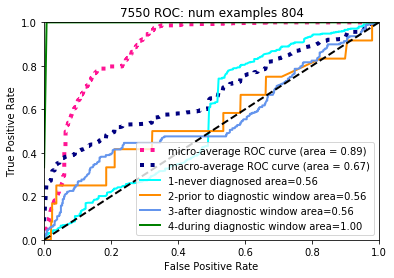

study 4380 1/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 300, 301)     0           embedding_2[0][0]                
                                                                 aux_input[0][0]            

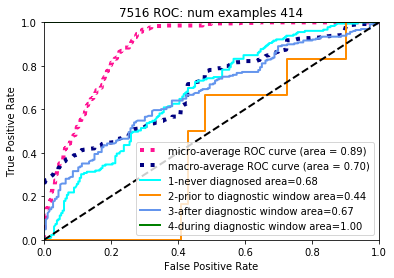

study 4418 3/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 300, 301)     0           embedding_4[0][0]                
                                                                 aux_input[0][0]            

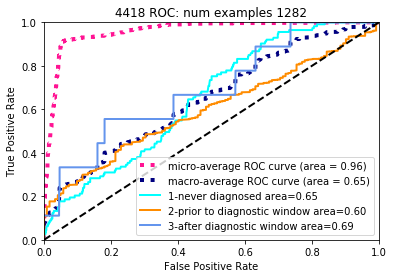

study 2169 4/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 300, 301)     0           embedding_5[0][0]                
                                                                 aux_input[0][0]            

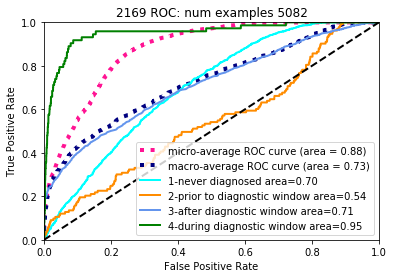

study 1473 5/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 300, 301)     0           embedding_6[0][0]                
                                                                 aux_input[0][0]            

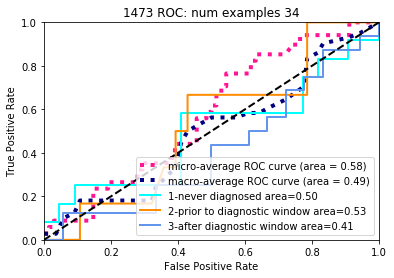

study 891 6/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 300, 301)     0           embedding_7[0][0]                
                                                                 aux_input[0][0]             

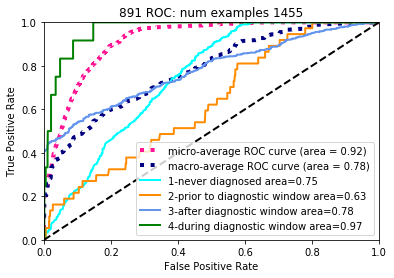

study 1313 7/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 300, 301)     0           embedding_8[0][0]                
                                                                 aux_input[0][0]            

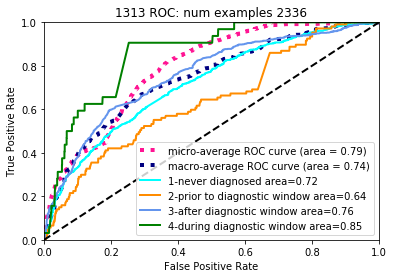

study 2019 8/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 300, 301)     0           embedding_9[0][0]                
                                                                 aux_input[0][0]            

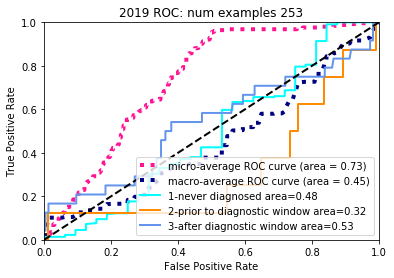

study 7514 9/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 300, 301)     0           embedding_10[0][0]               
                                                                 aux_input[0][0]            

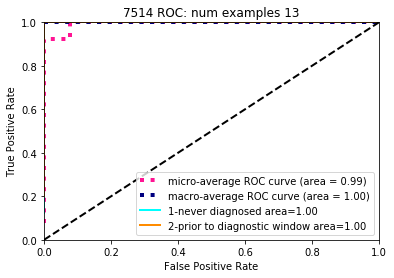

study 967 10/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 300, 301)     0           embedding_11[0][0]               
                                                                 aux_input[0][0]            

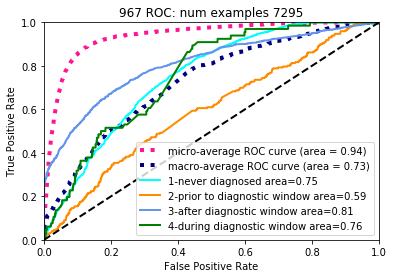

study 991 11/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 300, 301)     0           embedding_12[0][0]               
                                                                 aux_input[0][0]            

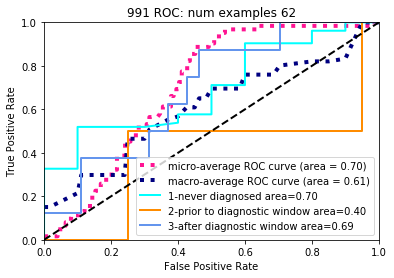

study 963 12/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 300, 301)     0           embedding_13[0][0]               
                                                                 aux_input[0][0]            

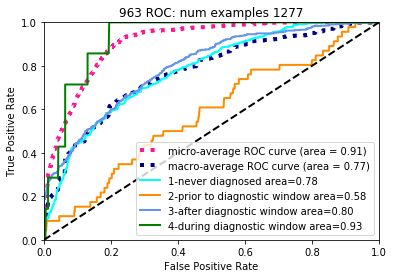

study 96 13/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 300, 301)     0           embedding_14[0][0]               
                                                                 aux_input[0][0]             

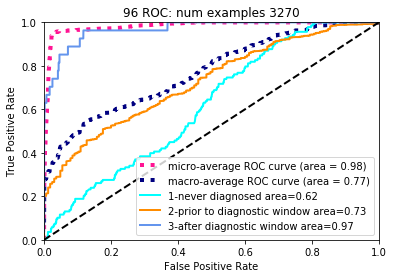

study f6fd297b-7dbb-40f7-90d5-4837c320570f 14/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 300, 301)     0           embedding_15[0][0]               
                                                           

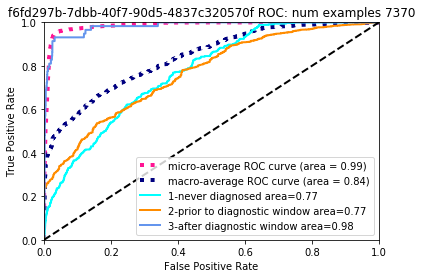

study 511 15/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 300, 301)     0           embedding_16[0][0]               
                                                                 aux_input[0][0]            

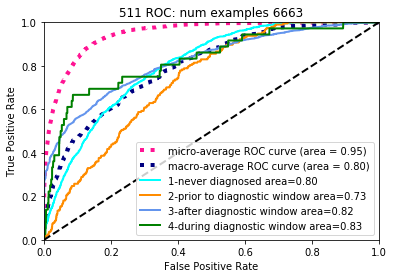

study 1849 16/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 300, 301)     0           embedding_17[0][0]               
                                                                 aux_input[0][0]           

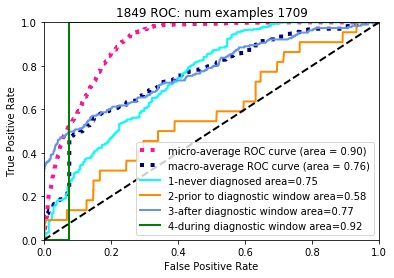

study 560 17/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_18 (Concatenate)    (None, 300, 301)     0           embedding_18[0][0]               
                                                                 aux_input[0][0]            

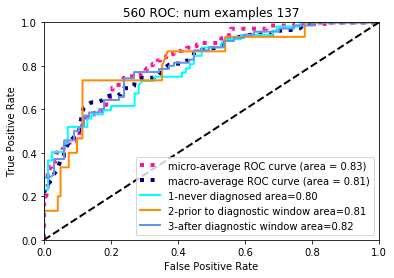

study 1624 18/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_19 (Concatenate)    (None, 300, 301)     0           embedding_19[0][0]               
                                                                 aux_input[0][0]           

/home/noel/tensorflow/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/noel/tensorflow/lib/python3.5/site-packages/sklearn/metrics/ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


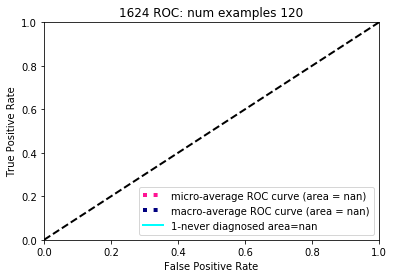

study 2228 19/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 300, 301)     0           embedding_20[0][0]               
                                                                 aux_input[0][0]           

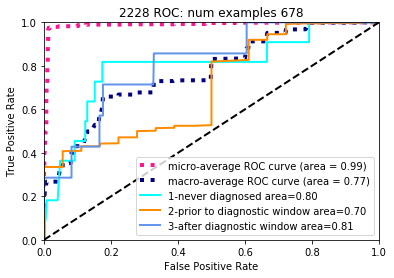

study 7028 20/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_21 (Concatenate)    (None, 300, 301)     0           embedding_21[0][0]               
                                                                 aux_input[0][0]           

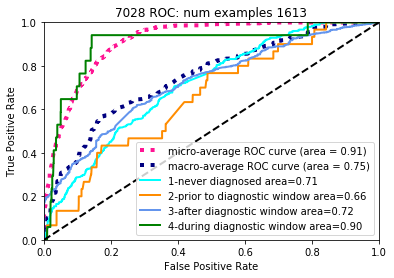

study e3acc57b-584f-4290-92de-32242526ef77 21/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_22 (Concatenate)    (None, 300, 301)     0           embedding_22[0][0]               
                                                           

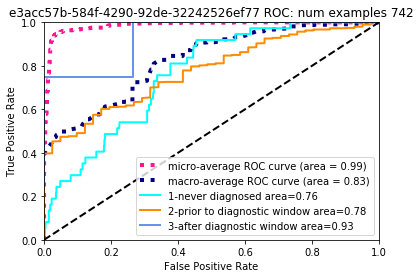

study 1bc06999-e70d-42f1-ac01-5d7ef6d8df4b 22/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 300, 301)     0           embedding_23[0][0]               
                                                           

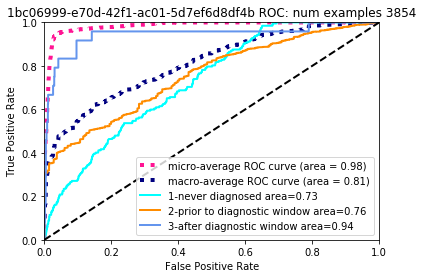

study 684 23/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 300, 301)     0           embedding_24[0][0]               
                                                                 aux_input[0][0]            

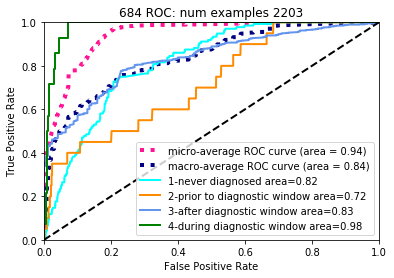

study 2292 24/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_25 (Concatenate)    (None, 300, 301)     0           embedding_25[0][0]               
                                                                 aux_input[0][0]           

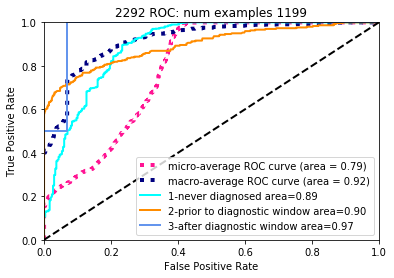

study 1779 25/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_26 (Concatenate)    (None, 300, 301)     0           embedding_26[0][0]               
                                                                 aux_input[0][0]           

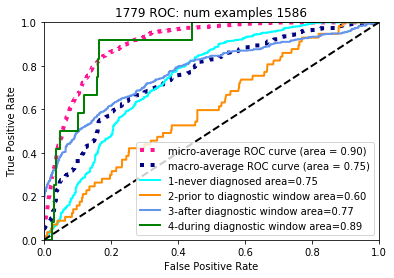

study 103 26/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_27 (Concatenate)    (None, 300, 301)     0           embedding_27[0][0]               
                                                                 aux_input[0][0]            

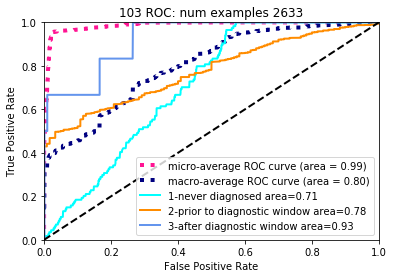

study 4bb814fe-5f8d-417c-a015-9c60767db9c6 27/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 300, 301)     0           embedding_28[0][0]               
                                                           

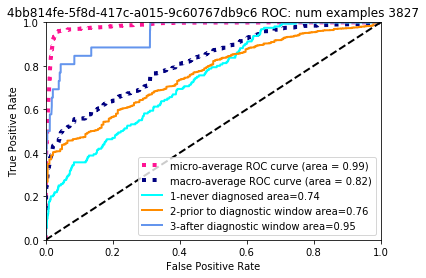

study 7627 28/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_29 (Concatenate)    (None, 300, 301)     0           embedding_29[0][0]               
                                                                 aux_input[0][0]           

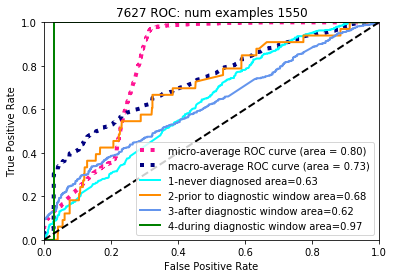

study 1014 29/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_30 (Concatenate)    (None, 300, 301)     0           embedding_30[0][0]               
                                                                 aux_input[0][0]           

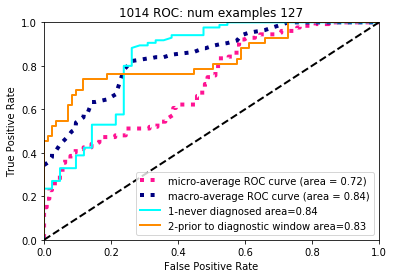

study 1096 30/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_31 (Concatenate)    (None, 300, 301)     0           embedding_31[0][0]               
                                                                 aux_input[0][0]           

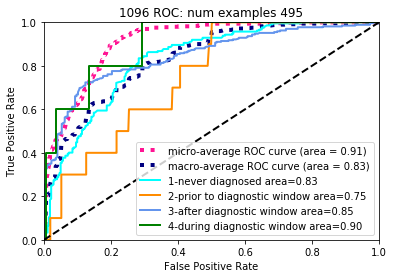

study 2106 31/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_32 (Concatenate)    (None, 300, 301)     0           embedding_32[0][0]               
                                                                 aux_input[0][0]           

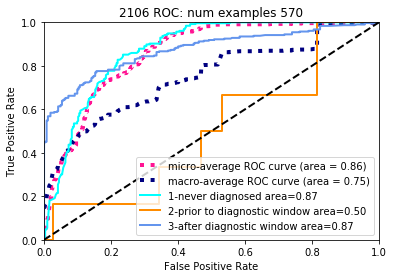

study 85d2a38e-e0ae-464f-8d5a-001b4d303e15 32/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_33 (Concatenate)    (None, 300, 301)     0           embedding_33[0][0]               
                                                           

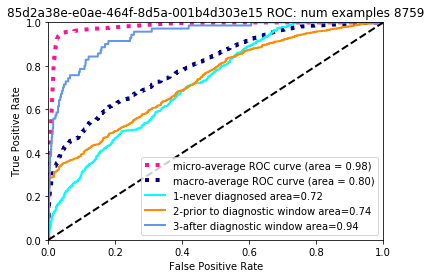

study 1685 33/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_34 (Concatenate)    (None, 300, 301)     0           embedding_34[0][0]               
                                                                 aux_input[0][0]           

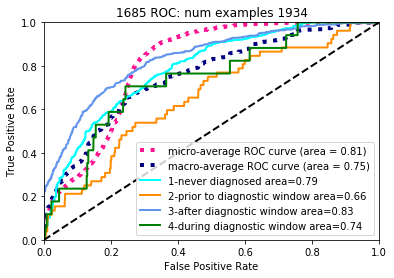

study 93 34/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_35 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_35 (Concatenate)    (None, 300, 301)     0           embedding_35[0][0]               
                                                                 aux_input[0][0]             

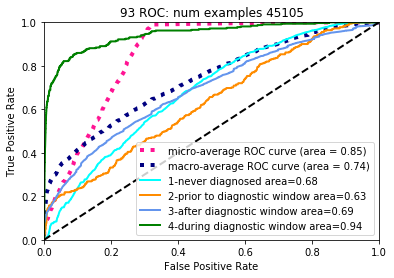

study 829 35/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_36 (Concatenate)    (None, 300, 301)     0           embedding_36[0][0]               
                                                                 aux_input[0][0]            

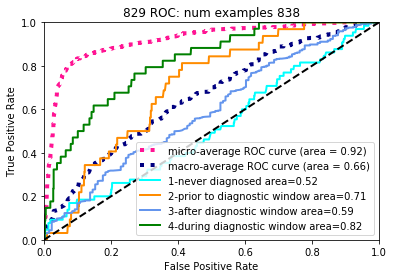

study c879ac8f-a8ee-4f40-b665-7faef159746c 36/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_37 (Concatenate)    (None, 300, 301)     0           embedding_37[0][0]               
                                                           

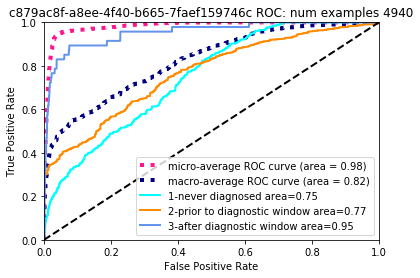

study 71d6df39-943c-4174-865c-0540f72d6c2a 37/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_38 (Concatenate)    (None, 300, 301)     0           embedding_38[0][0]               
                                                           

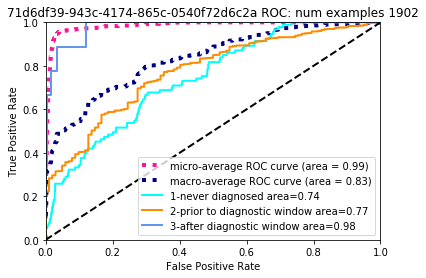

study 396 38/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_39 (Concatenate)    (None, 300, 301)     0           embedding_39[0][0]               
                                                                 aux_input[0][0]            

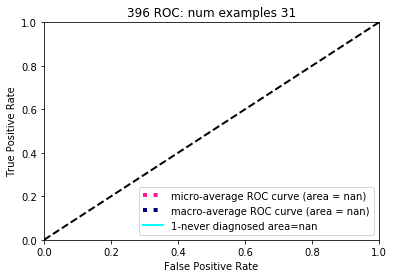

study 98 39/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_40 (Concatenate)    (None, 300, 301)     0           embedding_40[0][0]               
                                                                 aux_input[0][0]             

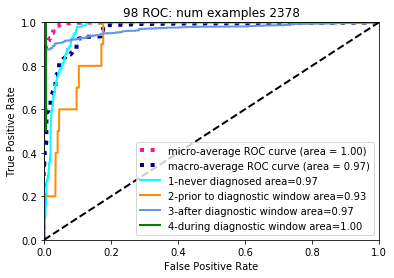

study 4756 40/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_41 (Concatenate)    (None, 300, 301)     0           embedding_41[0][0]               
                                                                 aux_input[0][0]           

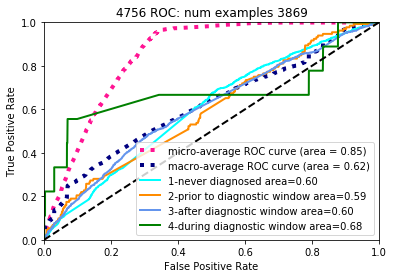

study 19783 41/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_42 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_42 (Concatenate)    (None, 300, 301)     0           embedding_42[0][0]               
                                                                 aux_input[0][0]          

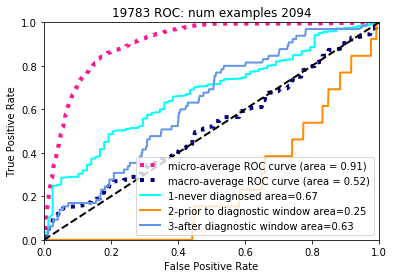

study 567 42/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_43 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_43 (Concatenate)    (None, 300, 301)     0           embedding_43[0][0]               
                                                                 aux_input[0][0]            

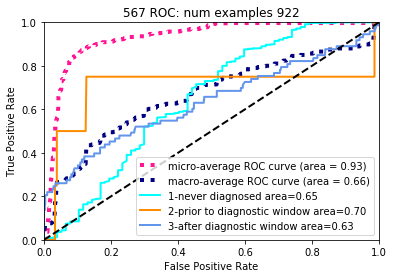

study 740 43/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_44 (Concatenate)    (None, 300, 301)     0           embedding_44[0][0]               
                                                                 aux_input[0][0]            

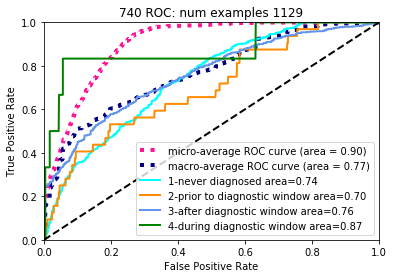

study 90 44/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_45 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_45 (Concatenate)    (None, 300, 301)     0           embedding_45[0][0]               
                                                                 aux_input[0][0]             

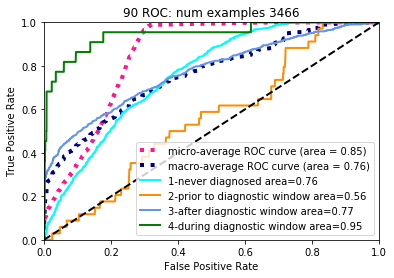

study 1534 45/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_46 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_46 (Concatenate)    (None, 300, 301)     0           embedding_46[0][0]               
                                                                 aux_input[0][0]           

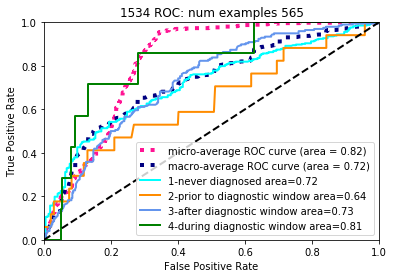

study 1678 46/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_47 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_47 (Concatenate)    (None, 300, 301)     0           embedding_47[0][0]               
                                                                 aux_input[0][0]           

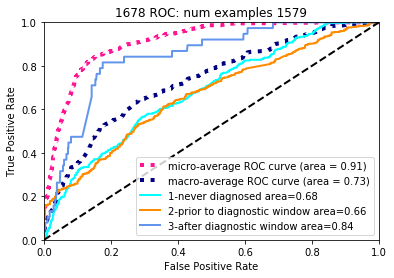

study 84 47/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_48 (Concatenate)    (None, 300, 301)     0           embedding_48[0][0]               
                                                                 aux_input[0][0]             

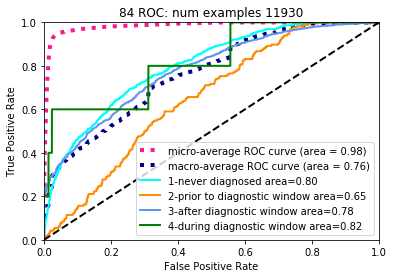

study 7573 48/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_49 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_49 (Concatenate)    (None, 300, 301)     0           embedding_49[0][0]               
                                                                 aux_input[0][0]           

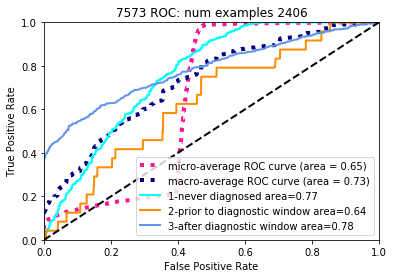

study 312 49/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_50 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_50 (Concatenate)    (None, 300, 301)     0           embedding_50[0][0]               
                                                                 aux_input[0][0]            

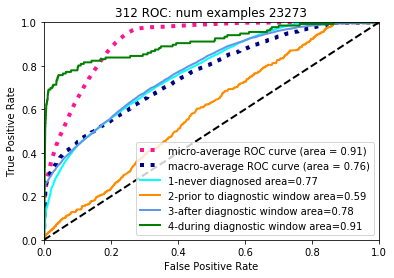

study 7890 50/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_51 (Concatenate)    (None, 300, 301)     0           embedding_51[0][0]               
                                                                 aux_input[0][0]           

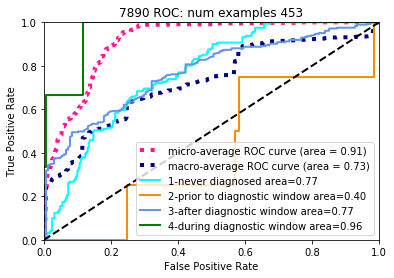

study 0ed9f72a-5b6b-4296-9743-411675d6cd4d 51/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_52 (Concatenate)    (None, 300, 301)     0           embedding_52[0][0]               
                                                           

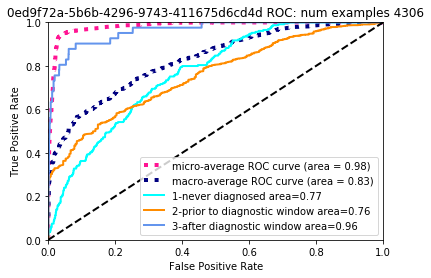

study 952 52/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_53 (Concatenate)    (None, 300, 301)     0           embedding_53[0][0]               
                                                                 aux_input[0][0]            

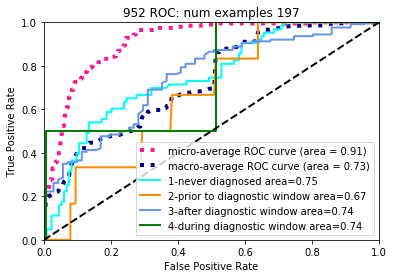

study 1503 53/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_54 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_54 (Concatenate)    (None, 300, 301)     0           embedding_54[0][0]               
                                                                 aux_input[0][0]           

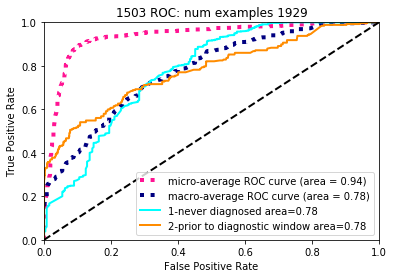

study 979 54/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_55 (Concatenate)    (None, 300, 301)     0           embedding_55[0][0]               
                                                                 aux_input[0][0]            

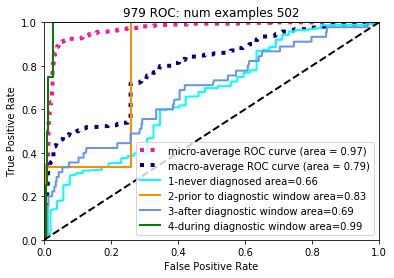

study 7604 55/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_56 (Concatenate)    (None, 300, 301)     0           embedding_56[0][0]               
                                                                 aux_input[0][0]           

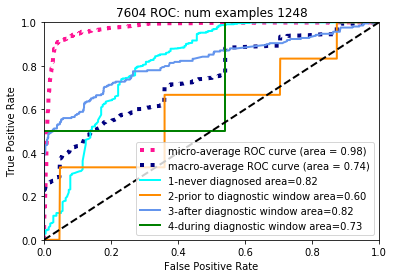

study 565 56/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_57 (Concatenate)    (None, 300, 301)     0           embedding_57[0][0]               
                                                                 aux_input[0][0]            

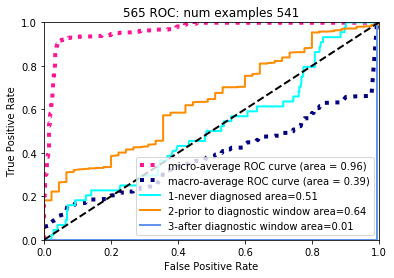

study b0a61acd-b4cb-4f54-b294-95effb485245 57/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_58 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_58 (Concatenate)    (None, 300, 301)     0           embedding_58[0][0]               
                                                           

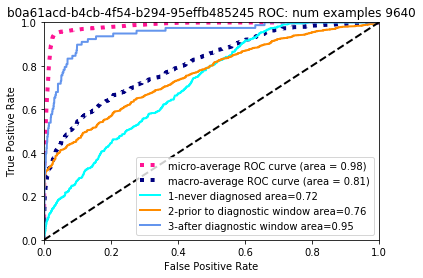

study 1287 58/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_59 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_59 (Concatenate)    (None, 300, 301)     0           embedding_59[0][0]               
                                                                 aux_input[0][0]           

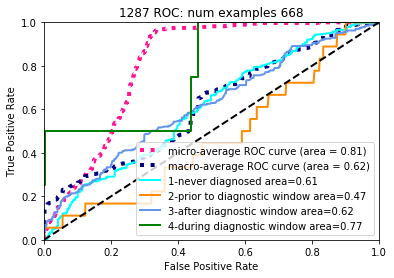

study 999 59/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_60 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_60 (Concatenate)    (None, 300, 301)     0           embedding_60[0][0]               
                                                                 aux_input[0][0]            

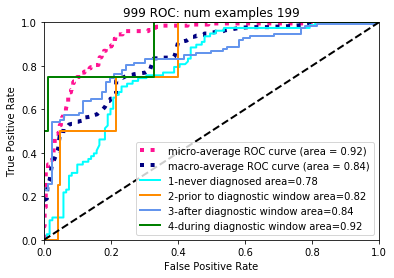

study 1074 60/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_61 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_61 (Concatenate)    (None, 300, 301)     0           embedding_61[0][0]               
                                                                 aux_input[0][0]           

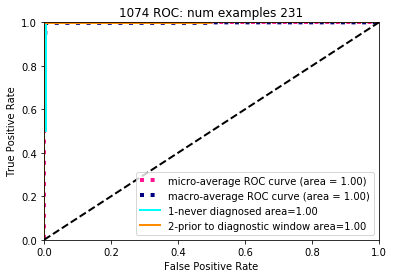

study 1914 61/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_62 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_62 (Concatenate)    (None, 300, 301)     0           embedding_62[0][0]               
                                                                 aux_input[0][0]           

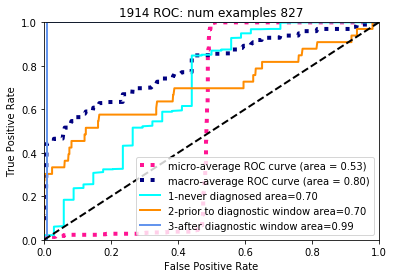

study 17981 62/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_63 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_63 (Concatenate)    (None, 300, 301)     0           embedding_63[0][0]               
                                                                 aux_input[0][0]          

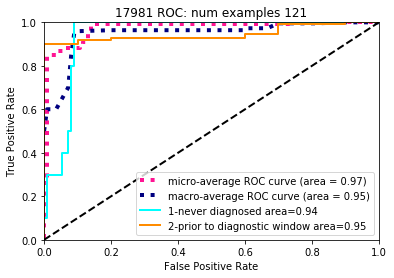

study 5862 63/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_64 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_64 (Concatenate)    (None, 300, 301)     0           embedding_64[0][0]               
                                                                 aux_input[0][0]           

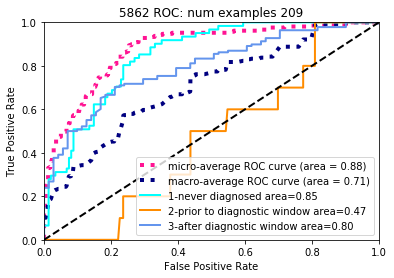

study 1150 64/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_65 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_65 (Concatenate)    (None, 300, 301)     0           embedding_65[0][0]               
                                                                 aux_input[0][0]           

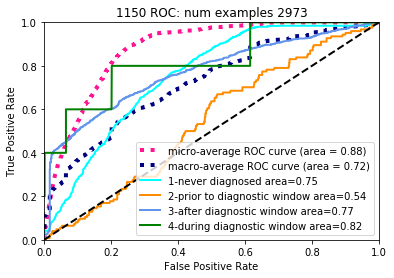

study 625 65/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_66 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_66 (Concatenate)    (None, 300, 301)     0           embedding_66[0][0]               
                                                                 aux_input[0][0]            

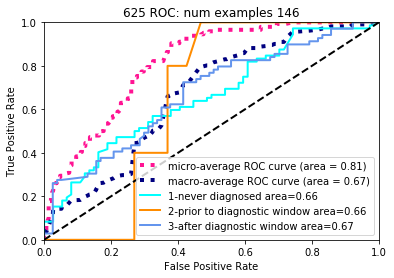

study 1786 66/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_67 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_67 (Concatenate)    (None, 300, 301)     0           embedding_67[0][0]               
                                                                 aux_input[0][0]           

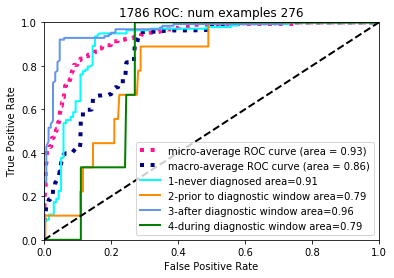

study 583 67/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_68 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_68 (Concatenate)    (None, 300, 301)     0           embedding_68[0][0]               
                                                                 aux_input[0][0]            

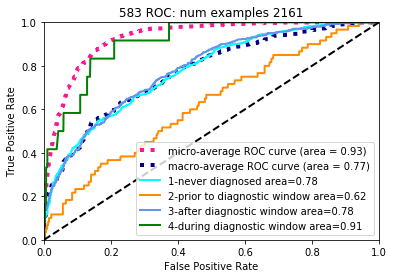

study 1338 68/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_69 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_69 (Concatenate)    (None, 300, 301)     0           embedding_69[0][0]               
                                                                 aux_input[0][0]           

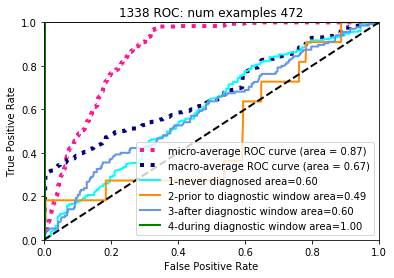

study 1097 69/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_70 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_70 (Concatenate)    (None, 300, 301)     0           embedding_70[0][0]               
                                                                 aux_input[0][0]           

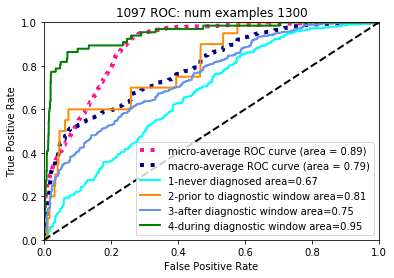

study 1609 70/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_71 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_71 (Concatenate)    (None, 300, 301)     0           embedding_71[0][0]               
                                                                 aux_input[0][0]           

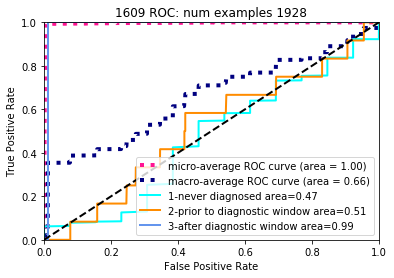

study 74 71/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_72 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_72 (Concatenate)    (None, 300, 301)     0           embedding_72[0][0]               
                                                                 aux_input[0][0]             

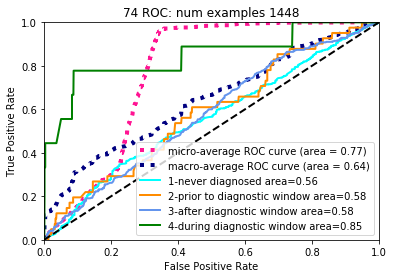

study 2187 72/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_73 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_73 (Concatenate)    (None, 300, 301)     0           embedding_73[0][0]               
                                                                 aux_input[0][0]           

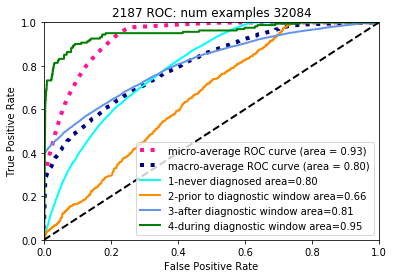

study 2242 73/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_74 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_74 (Concatenate)    (None, 300, 301)     0           embedding_74[0][0]               
                                                                 aux_input[0][0]           

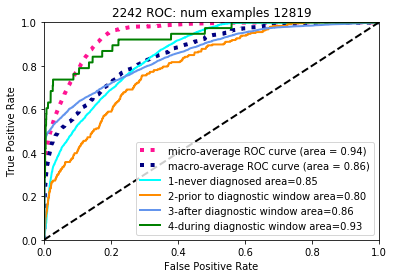

study 518 74/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_75 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_75 (Concatenate)    (None, 300, 301)     0           embedding_75[0][0]               
                                                                 aux_input[0][0]            

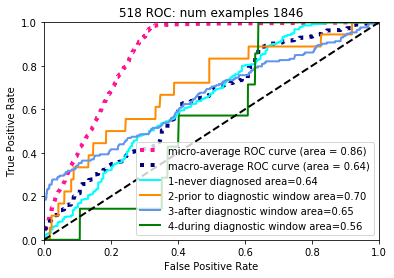

study 668 75/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_76 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_76 (Concatenate)    (None, 300, 301)     0           embedding_76[0][0]               
                                                                 aux_input[0][0]            

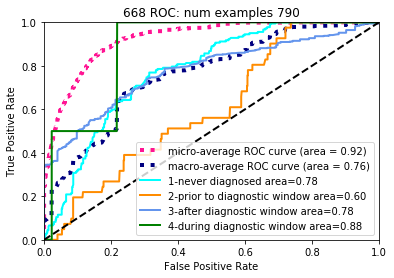

study bc030e37-1838-473c-a854-1300febca9e1 76/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_77 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_77 (Concatenate)    (None, 300, 301)     0           embedding_77[0][0]               
                                                           

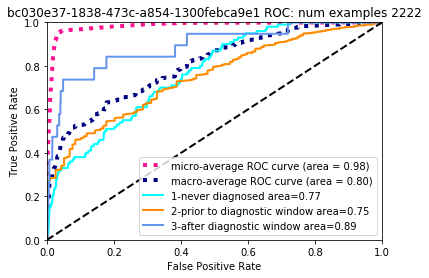

study 1060 77/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_78 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_78 (Concatenate)    (None, 300, 301)     0           embedding_78[0][0]               
                                                                 aux_input[0][0]           

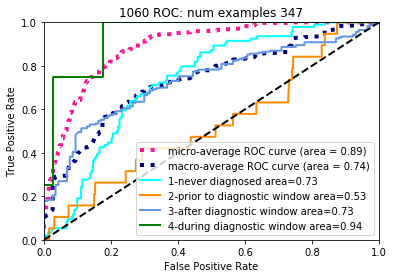

study 2176 78/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_79 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_79 (Concatenate)    (None, 300, 301)     0           embedding_79[0][0]               
                                                                 aux_input[0][0]           

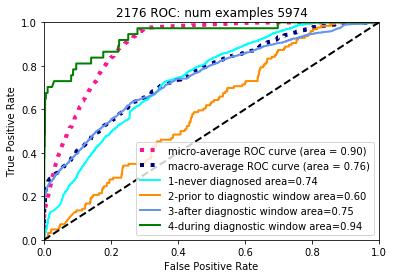

study 895 79/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_80 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_80 (Concatenate)    (None, 300, 301)     0           embedding_80[0][0]               
                                                                 aux_input[0][0]            

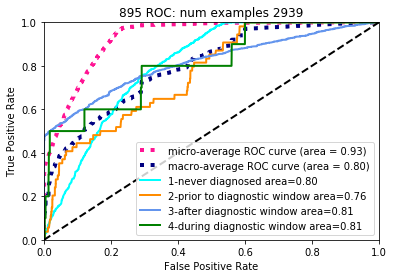

study 18779 80/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_81 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_81 (Concatenate)    (None, 300, 301)     0           embedding_81[0][0]               
                                                                 aux_input[0][0]          

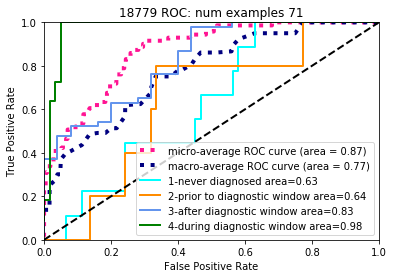

study 718 81/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_82 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_82 (Concatenate)    (None, 300, 301)     0           embedding_82[0][0]               
                                                                 aux_input[0][0]            

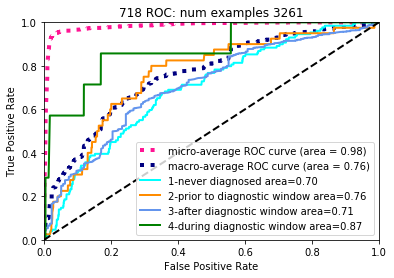

study 1046 82/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_83 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_83 (Concatenate)    (None, 300, 301)     0           embedding_83[0][0]               
                                                                 aux_input[0][0]           

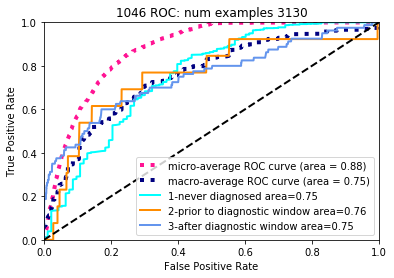

study 1683 83/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_84 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_84 (Concatenate)    (None, 300, 301)     0           embedding_84[0][0]               
                                                                 aux_input[0][0]           

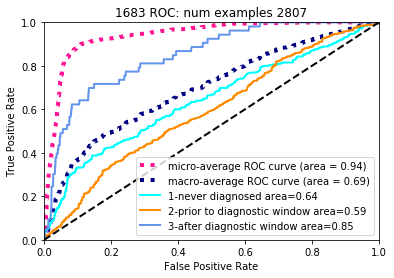

study 1290 84/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_85 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_85 (Concatenate)    (None, 300, 301)     0           embedding_85[0][0]               
                                                                 aux_input[0][0]           

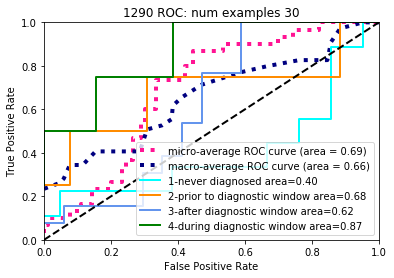

study 2255 85/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_86 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_86 (Concatenate)    (None, 300, 301)     0           embedding_86[0][0]               
                                                                 aux_input[0][0]           

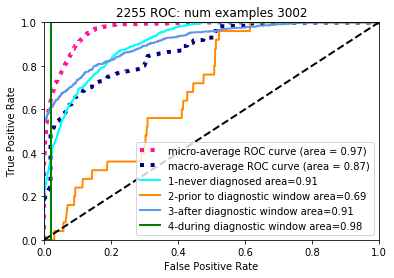

study 2899 86/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_87 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_87 (Concatenate)    (None, 300, 301)     0           embedding_87[0][0]               
                                                                 aux_input[0][0]           

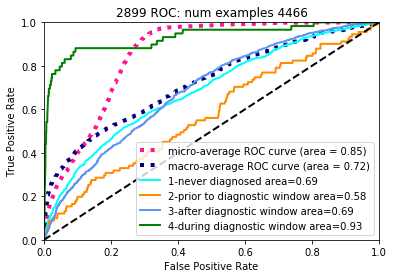

study 2206 87/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_88 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_88 (Concatenate)    (None, 300, 301)     0           embedding_88[0][0]               
                                                                 aux_input[0][0]           

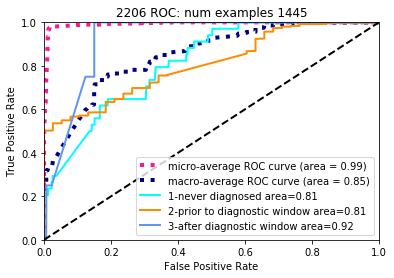

study 676 88/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_89 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_89 (Concatenate)    (None, 300, 301)     0           embedding_89[0][0]               
                                                                 aux_input[0][0]            

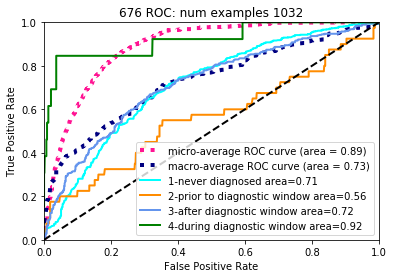

study 2164 89/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_90 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_90 (Concatenate)    (None, 300, 301)     0           embedding_90[0][0]               
                                                                 aux_input[0][0]           

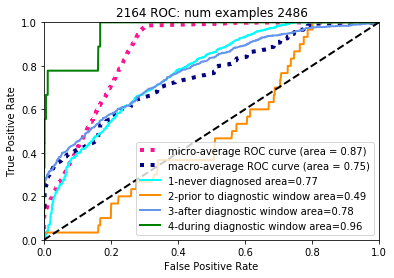

study 1964 90/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_91 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_91 (Concatenate)    (None, 300, 301)     0           embedding_91[0][0]               
                                                                 aux_input[0][0]           

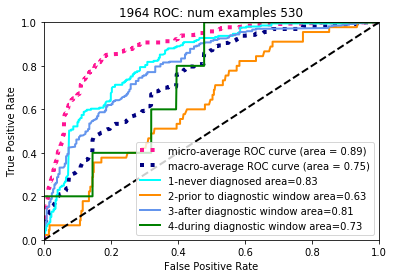

study 1063 91/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_92 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_92 (Concatenate)    (None, 300, 301)     0           embedding_92[0][0]               
                                                                 aux_input[0][0]           

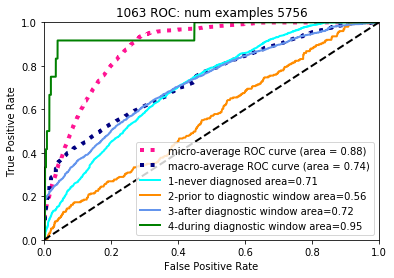

study 1751 92/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_93 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_93 (Concatenate)    (None, 300, 301)     0           embedding_93[0][0]               
                                                                 aux_input[0][0]           

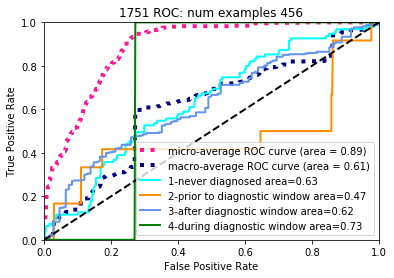

study 5b4196d1-ecbf-4895-9cff-822b84203509 93/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_94 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_94 (Concatenate)    (None, 300, 301)     0           embedding_94[0][0]               
                                                           

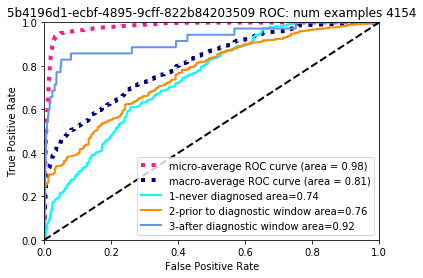

study 43 94/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_95 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_95 (Concatenate)    (None, 300, 301)     0           embedding_95[0][0]               
                                                                 aux_input[0][0]             

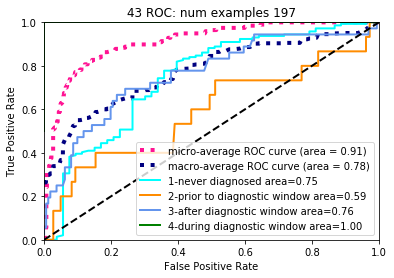

study 7587 95/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_96 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_96 (Concatenate)    (None, 300, 301)     0           embedding_96[0][0]               
                                                                 aux_input[0][0]           

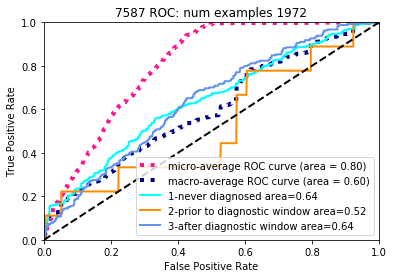

study 1913 96/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_97 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_97 (Concatenate)    (None, 300, 301)     0           embedding_97[0][0]               
                                                                 aux_input[0][0]           

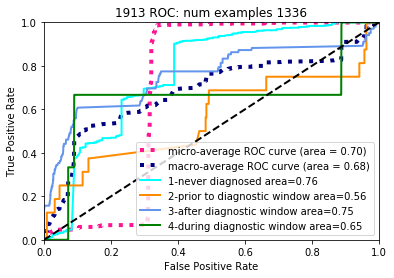

study 7580 97/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_98 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_98 (Concatenate)    (None, 300, 301)     0           embedding_98[0][0]               
                                                                 aux_input[0][0]           

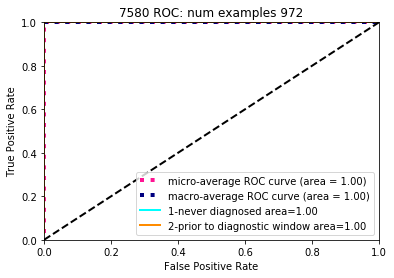

study 1840 98/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_99 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_99 (Concatenate)    (None, 300, 301)     0           embedding_99[0][0]               
                                                                 aux_input[0][0]           

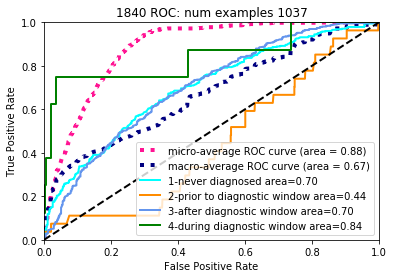

study 624 99/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_100 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_100 (Concatenate)   (None, 300, 301)     0           embedding_100[0][0]              
                                                                 aux_input[0][0]            

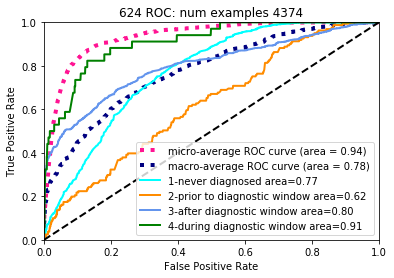

study 9667 100/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_101 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_101 (Concatenate)   (None, 300, 301)     0           embedding_101[0][0]              
                                                                 aux_input[0][0]          

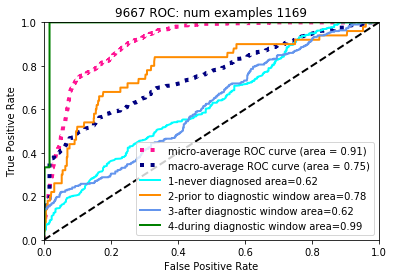

study 79 101/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_102 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_102 (Concatenate)   (None, 300, 301)     0           embedding_102[0][0]              
                                                                 aux_input[0][0]            

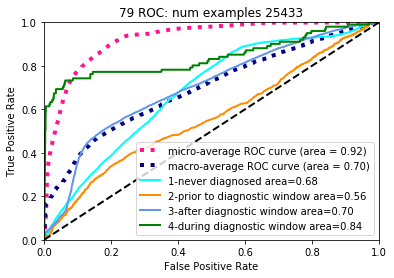

study 593 102/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_103 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_103 (Concatenate)   (None, 300, 301)     0           embedding_103[0][0]              
                                                                 aux_input[0][0]           

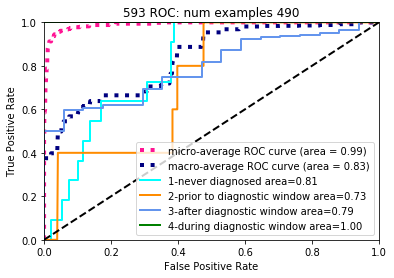

study 1785 103/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_104 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_104 (Concatenate)   (None, 300, 301)     0           embedding_104[0][0]              
                                                                 aux_input[0][0]          

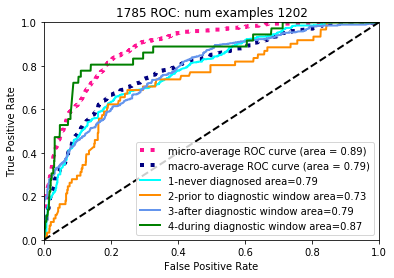

study 2031 104/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_105 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_105 (Concatenate)   (None, 300, 301)     0           embedding_105[0][0]              
                                                                 aux_input[0][0]          

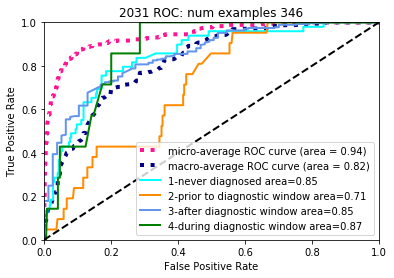

study 2162 105/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_106 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_106 (Concatenate)   (None, 300, 301)     0           embedding_106[0][0]              
                                                                 aux_input[0][0]          

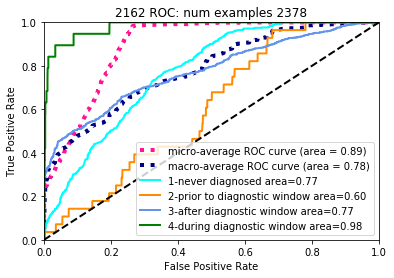

study 2284 106/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_107 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_107 (Concatenate)   (None, 300, 301)     0           embedding_107[0][0]              
                                                                 aux_input[0][0]          

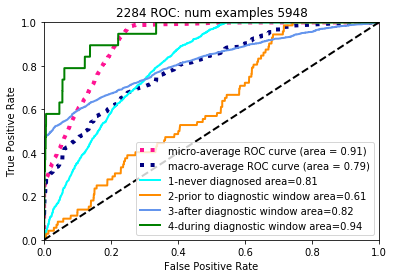

study 466 107/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_108 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_108 (Concatenate)   (None, 300, 301)     0           embedding_108[0][0]              
                                                                 aux_input[0][0]           

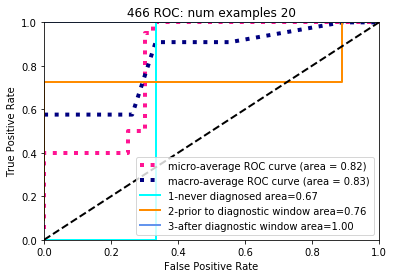

study 889 108/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_109 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_109 (Concatenate)   (None, 300, 301)     0           embedding_109[0][0]              
                                                                 aux_input[0][0]           

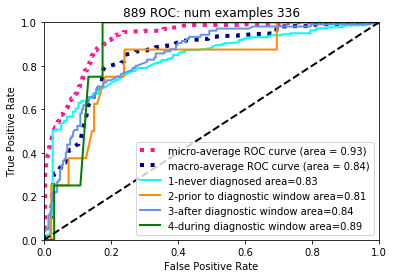

study 20267 109/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_110 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_110 (Concatenate)   (None, 300, 301)     0           embedding_110[0][0]              
                                                                 aux_input[0][0]         

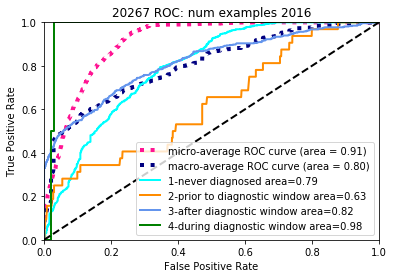

study 4566 110/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_111 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_111 (Concatenate)   (None, 300, 301)     0           embedding_111[0][0]              
                                                                 aux_input[0][0]          

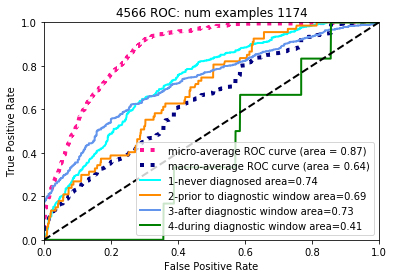

study 350 111/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_112 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_112 (Concatenate)   (None, 300, 301)     0           embedding_112[0][0]              
                                                                 aux_input[0][0]           

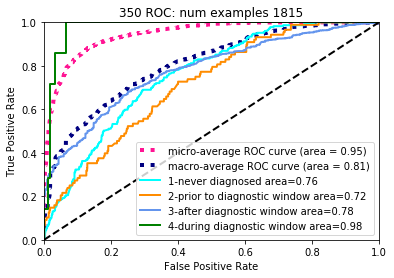

study 15219 112/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_113 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_113 (Concatenate)   (None, 300, 301)     0           embedding_113[0][0]              
                                                                 aux_input[0][0]         

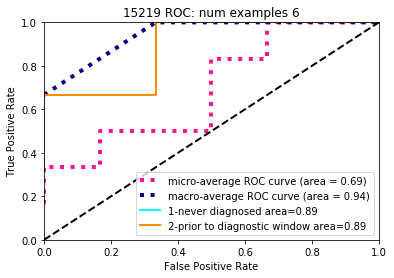

study 562 113/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_114 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_114 (Concatenate)   (None, 300, 301)     0           embedding_114[0][0]              
                                                                 aux_input[0][0]           

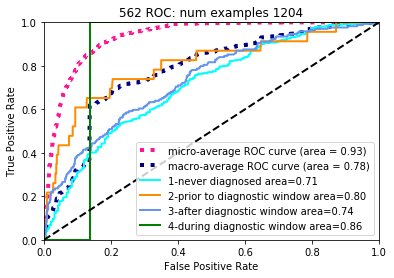

study 4e278045-23d2-46e7-9c39-748b9600d694 114/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_115 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_115 (Concatenate)   (None, 300, 301)     0           embedding_115[0][0]              
                                                          

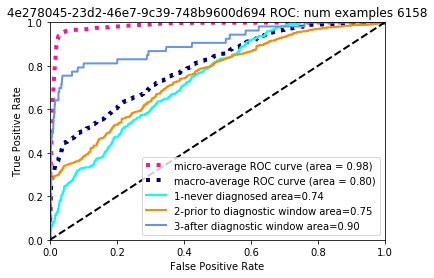

study 11013 115/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_116 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_116 (Concatenate)   (None, 300, 301)     0           embedding_116[0][0]              
                                                                 aux_input[0][0]         

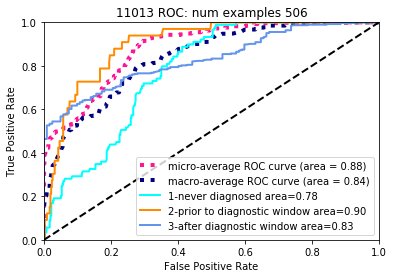

study 529 116/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_117 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_117 (Concatenate)   (None, 300, 301)     0           embedding_117[0][0]              
                                                                 aux_input[0][0]           

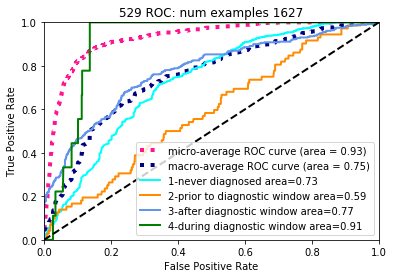

study 5400 117/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_118 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_118 (Concatenate)   (None, 300, 301)     0           embedding_118[0][0]              
                                                                 aux_input[0][0]          

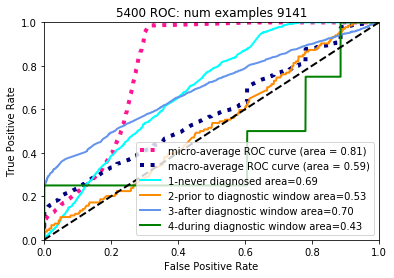

study 057ecdcb-64fc-4f50-ac86-70eea72301ff 118/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_119 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_119 (Concatenate)   (None, 300, 301)     0           embedding_119[0][0]              
                                                          

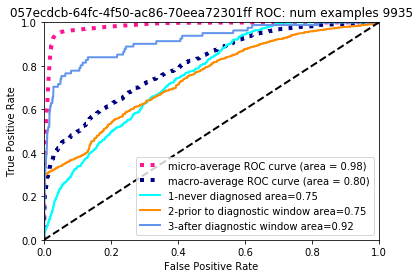

study 8425ec75-183e-4281-adb0-ba5d27947bd3 119/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_120 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_120 (Concatenate)   (None, 300, 301)     0           embedding_120[0][0]              
                                                          

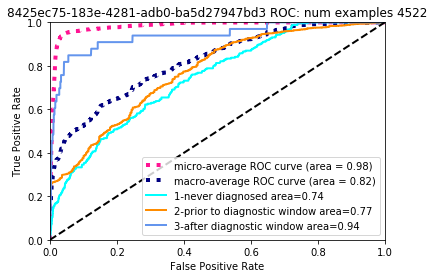

study 975 120/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_121 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_121 (Concatenate)   (None, 300, 301)     0           embedding_121[0][0]              
                                                                 aux_input[0][0]           

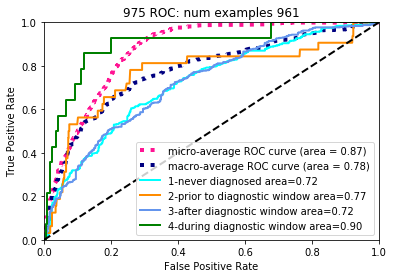

study 921 121/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_122 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_122 (Concatenate)   (None, 300, 301)     0           embedding_122[0][0]              
                                                                 aux_input[0][0]           

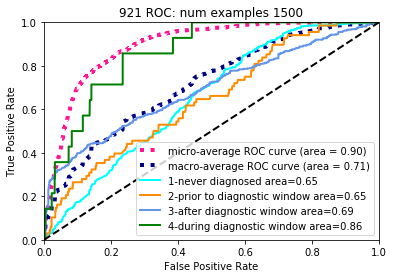

study 2075 122/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_123 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_123 (Concatenate)   (None, 300, 301)     0           embedding_123[0][0]              
                                                                 aux_input[0][0]          

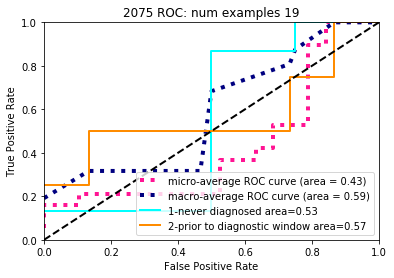

study 314c0838-3f0a-4a06-8aae-c3aefa581bf6 123/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_124 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_124 (Concatenate)   (None, 300, 301)     0           embedding_124[0][0]              
                                                          

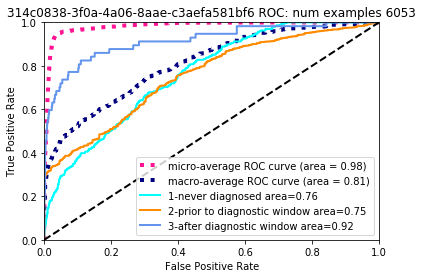

study 17179 124/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_125 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_125 (Concatenate)   (None, 300, 301)     0           embedding_125[0][0]              
                                                                 aux_input[0][0]         

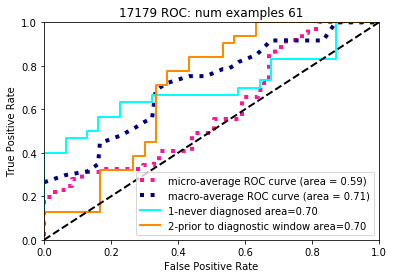

study 2263 125/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_126 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_126 (Concatenate)   (None, 300, 301)     0           embedding_126[0][0]              
                                                                 aux_input[0][0]          

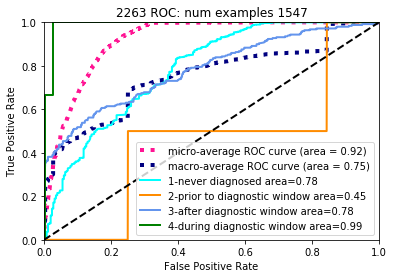

study 197 126/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_127 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_127 (Concatenate)   (None, 300, 301)     0           embedding_127[0][0]              
                                                                 aux_input[0][0]           

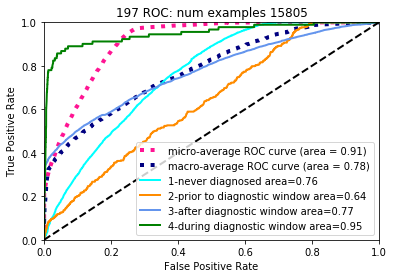

study 1153 127/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_128 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_128 (Concatenate)   (None, 300, 301)     0           embedding_128[0][0]              
                                                                 aux_input[0][0]          

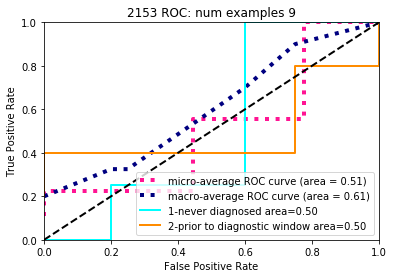

study 1228 129/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_130 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_130 (Concatenate)   (None, 300, 301)     0           embedding_130[0][0]              
                                                                 aux_input[0][0]          

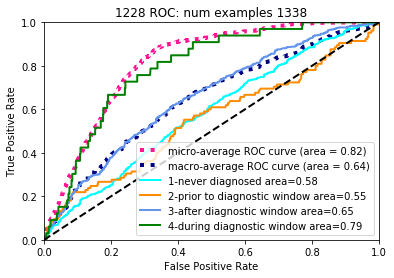

study 708 130/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_131 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_131 (Concatenate)   (None, 300, 301)     0           embedding_131[0][0]              
                                                                 aux_input[0][0]           

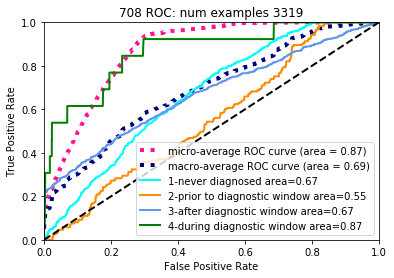

study 2151 131/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_132 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_132 (Concatenate)   (None, 300, 301)     0           embedding_132[0][0]              
                                                                 aux_input[0][0]          

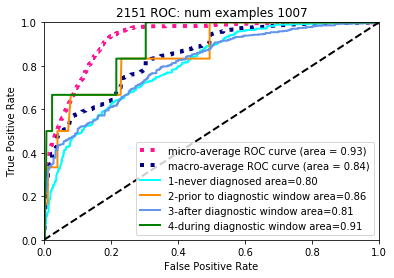

study 1610 132/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_133 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_133 (Concatenate)   (None, 300, 301)     0           embedding_133[0][0]              
                                                                 aux_input[0][0]          

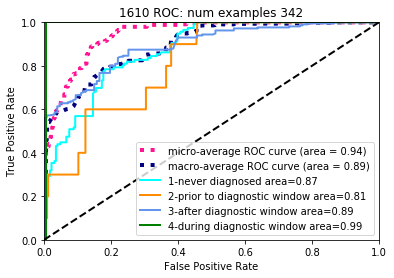

study 4334 133/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_134 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_134 (Concatenate)   (None, 300, 301)     0           embedding_134[0][0]              
                                                                 aux_input[0][0]          

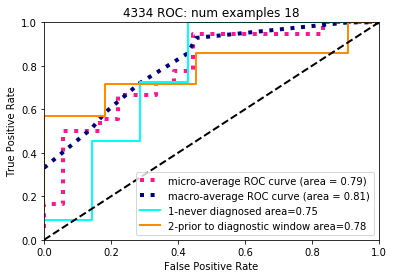

study 2127 134/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_135 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_135 (Concatenate)   (None, 300, 301)     0           embedding_135[0][0]              
                                                                 aux_input[0][0]          

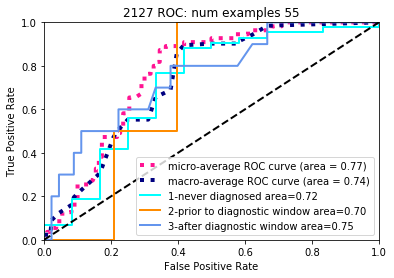

study 631 135/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_136 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_136 (Concatenate)   (None, 300, 301)     0           embedding_136[0][0]              
                                                                 aux_input[0][0]           

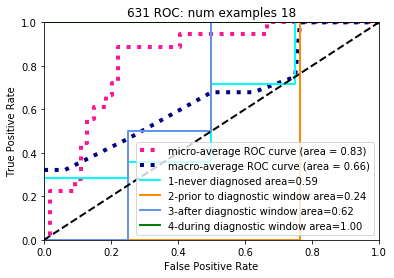

study 692 136/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_137 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_137 (Concatenate)   (None, 300, 301)     0           embedding_137[0][0]              
                                                                 aux_input[0][0]           

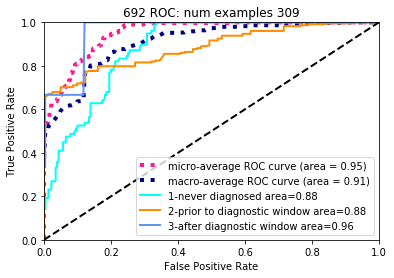

study 5399 137/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_138 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_138 (Concatenate)   (None, 300, 301)     0           embedding_138[0][0]              
                                                                 aux_input[0][0]          

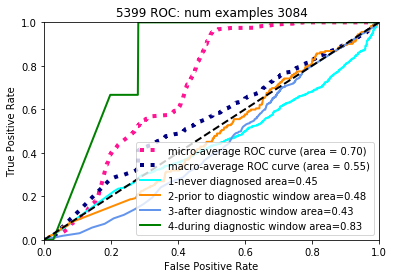

study 1776 138/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_139 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_139 (Concatenate)   (None, 300, 301)     0           embedding_139[0][0]              
                                                                 aux_input[0][0]          

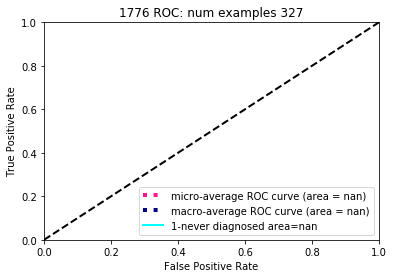

study 2134 139/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_140 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_140 (Concatenate)   (None, 300, 301)     0           embedding_140[0][0]              
                                                                 aux_input[0][0]          

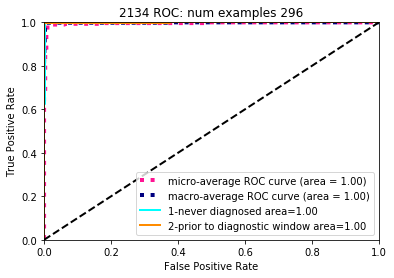

study 1045 140/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_141 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_141 (Concatenate)   (None, 300, 301)     0           embedding_141[0][0]              
                                                                 aux_input[0][0]          

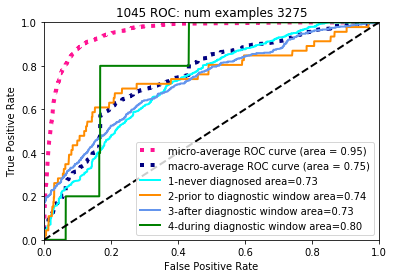

study 62 141/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_142 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_142 (Concatenate)   (None, 300, 301)     0           embedding_142[0][0]              
                                                                 aux_input[0][0]            

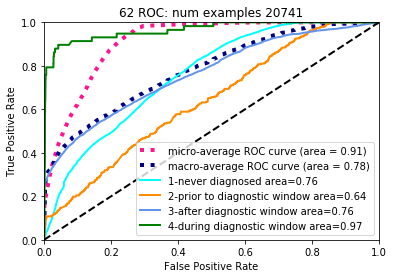

study 2083 142/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_143 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_143 (Concatenate)   (None, 300, 301)     0           embedding_143[0][0]              
                                                                 aux_input[0][0]          

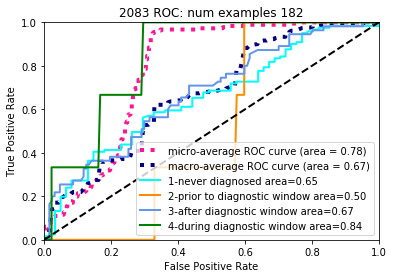

study 414 143/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_144 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_144 (Concatenate)   (None, 300, 301)     0           embedding_144[0][0]              
                                                                 aux_input[0][0]           

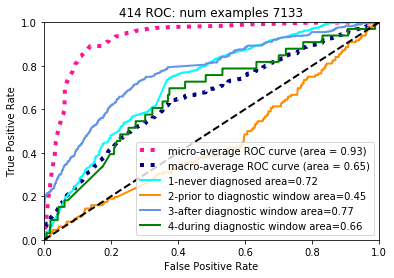

study 1577 144/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_145 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_145 (Concatenate)   (None, 300, 301)     0           embedding_145[0][0]              
                                                                 aux_input[0][0]          

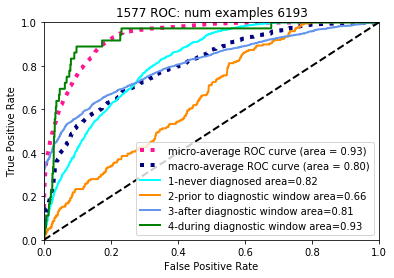

study 4fc3c861-922d-4e9b-af96-9b224e5952d9 145/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_146 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_146 (Concatenate)   (None, 300, 301)     0           embedding_146[0][0]              
                                                          

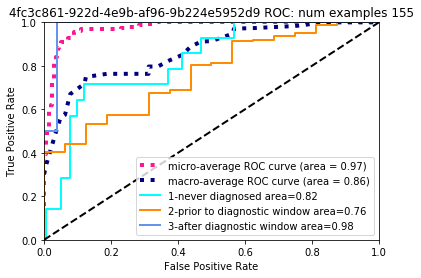

study 86 146/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_147 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_147 (Concatenate)   (None, 300, 301)     0           embedding_147[0][0]              
                                                                 aux_input[0][0]            

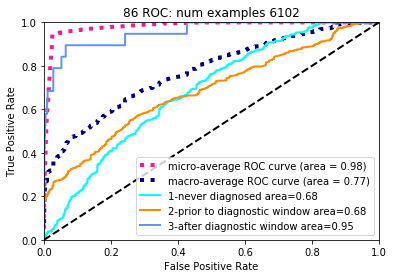

study 5788 147/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_148 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_148 (Concatenate)   (None, 300, 301)     0           embedding_148[0][0]              
                                                                 aux_input[0][0]          

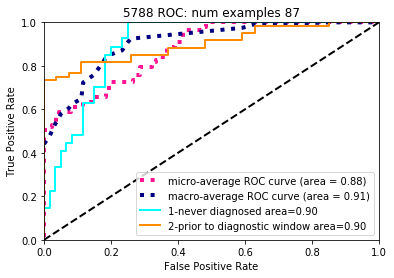

study c580b5cc-ba58-4bf1-8cca-7673d7b47d10 148/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_149 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_149 (Concatenate)   (None, 300, 301)     0           embedding_149[0][0]              
                                                          

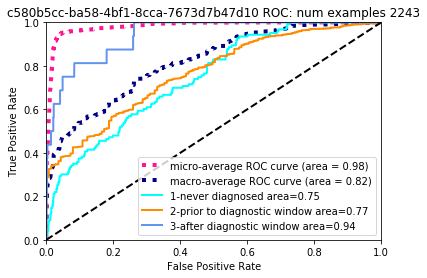

study 1037 149/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_150 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_150 (Concatenate)   (None, 300, 301)     0           embedding_150[0][0]              
                                                                 aux_input[0][0]          

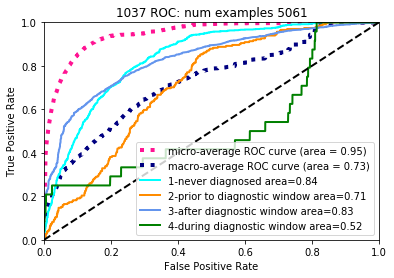

study 7637 150/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_151 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_151 (Concatenate)   (None, 300, 301)     0           embedding_151[0][0]              
                                                                 aux_input[0][0]          

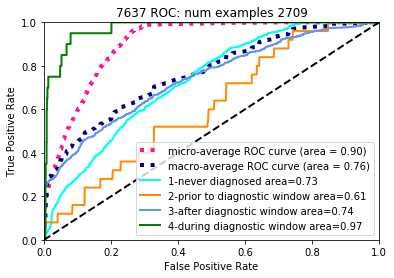

study 65 151/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_152 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_152 (Concatenate)   (None, 300, 301)     0           embedding_152[0][0]              
                                                                 aux_input[0][0]            

/home/noel/tensorflow/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


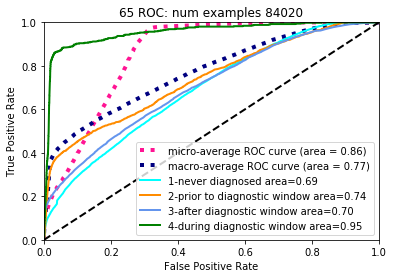

study 425 152/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_153 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_153 (Concatenate)   (None, 300, 301)     0           embedding_153[0][0]              
                                                                 aux_input[0][0]           

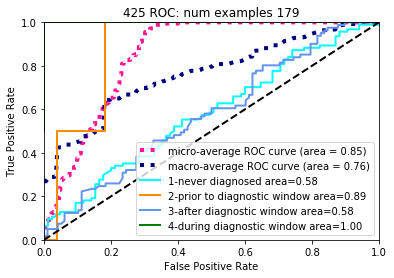

study 1658 153/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_154 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_154 (Concatenate)   (None, 300, 301)     0           embedding_154[0][0]              
                                                                 aux_input[0][0]          

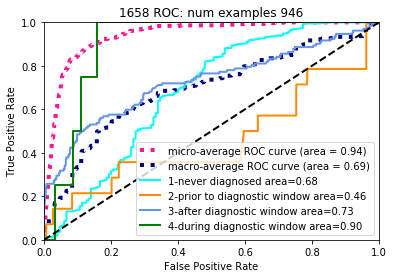

study 528 154/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_155 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_155 (Concatenate)   (None, 300, 301)     0           embedding_155[0][0]              
                                                                 aux_input[0][0]           

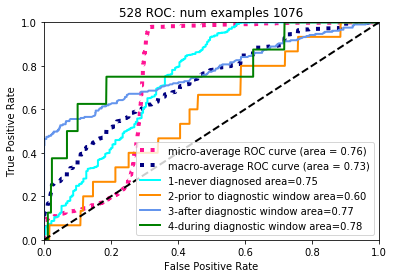

study 1760 155/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_156 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_156 (Concatenate)   (None, 300, 301)     0           embedding_156[0][0]              
                                                                 aux_input[0][0]          

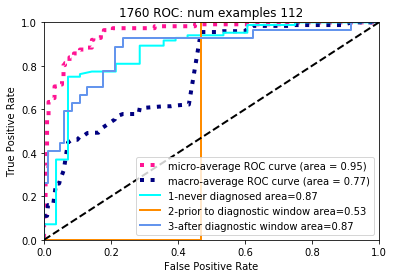

study f3d004bd-726b-4ee9-b23c-74fe26c242d6 156/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_157 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_157 (Concatenate)   (None, 300, 301)     0           embedding_157[0][0]              
                                                          

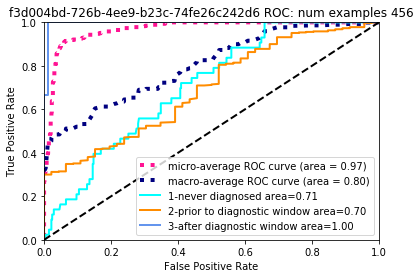

study 506 157/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_158 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_158 (Concatenate)   (None, 300, 301)     0           embedding_158[0][0]              
                                                                 aux_input[0][0]           

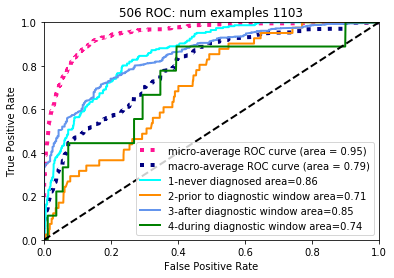

study 178 158/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_159 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_159 (Concatenate)   (None, 300, 301)     0           embedding_159[0][0]              
                                                                 aux_input[0][0]           

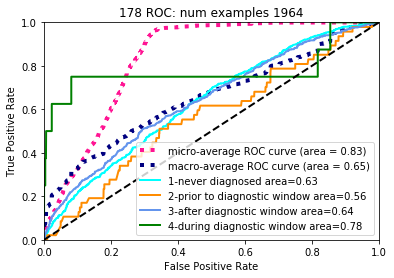

study 4742 159/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_160 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_160 (Concatenate)   (None, 300, 301)     0           embedding_160[0][0]              
                                                                 aux_input[0][0]          

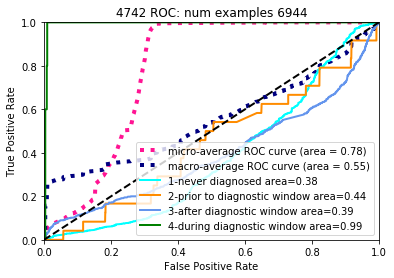

study 1360 160/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_161 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_161 (Concatenate)   (None, 300, 301)     0           embedding_161[0][0]              
                                                                 aux_input[0][0]          

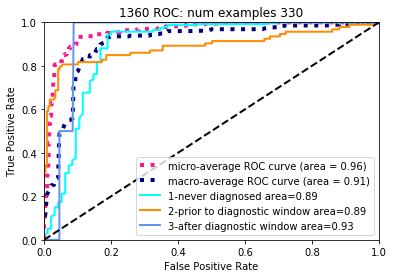

study 1938 161/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_162 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_162 (Concatenate)   (None, 300, 301)     0           embedding_162[0][0]              
                                                                 aux_input[0][0]          

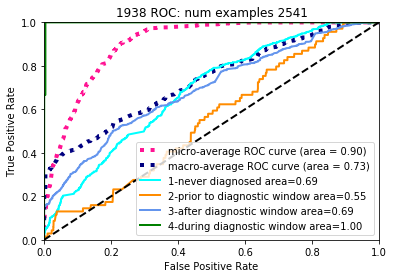

study 648 162/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_163 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_163 (Concatenate)   (None, 300, 301)     0           embedding_163[0][0]              
                                                                 aux_input[0][0]           

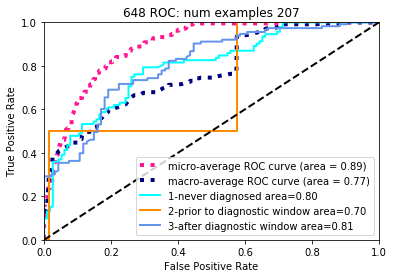

study 1937 163/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_164 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_164 (Concatenate)   (None, 300, 301)     0           embedding_164[0][0]              
                                                                 aux_input[0][0]          

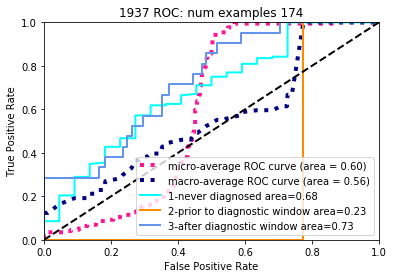

study 2288 164/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_165 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_165 (Concatenate)   (None, 300, 301)     0           embedding_165[0][0]              
                                                                 aux_input[0][0]          

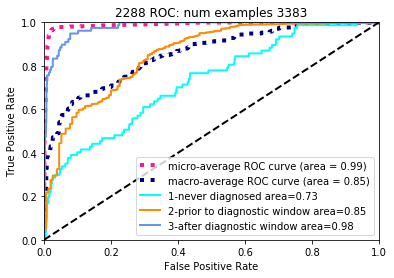

study 594 165/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_166 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_166 (Concatenate)   (None, 300, 301)     0           embedding_166[0][0]              
                                                                 aux_input[0][0]           

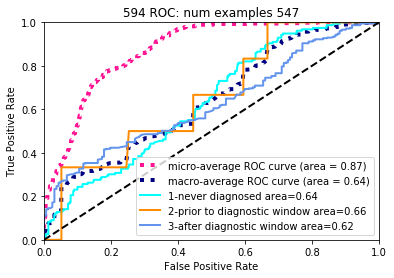

study 1025 166/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_167 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_167 (Concatenate)   (None, 300, 301)     0           embedding_167[0][0]              
                                                                 aux_input[0][0]          

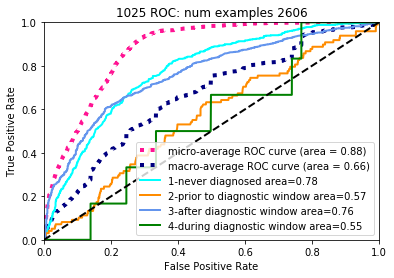

study 579 167/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_168 (Embedding)       (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_168 (Concatenate)   (None, 300, 301)     0           embedding_168[0][0]              
                                                                 aux_input[0][0]           

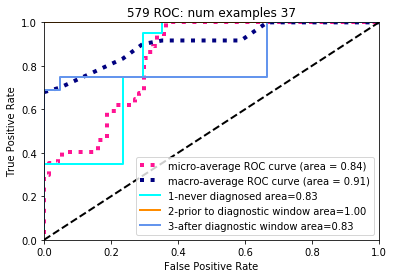

In [10]:
from livelossplot import PlotLossesKeras
from sklearn.metrics import roc_curve, auc
from scipy import interp
import json
import os.path
import random




study_rocuac={} # study per-class rocauc scores
study_indices={} # studyid -> y_pred/y_true indices
study_training_hx={} # studyid -> keras training history
y_pred_cum=np.zeros((0,4),dtype=dtype)
y_true_cum=np.zeros((0,4),dtype=dtype)
study_counter=0

# detect if we are resuming
if os.path.isfile('%s/heldout_disease_roc_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name)):
    # we are resuming, restore state
    
    # per study roc results
    with open('%s/heldout_disease_roc_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'r') as file:
        study_rocuac=json.load(file)
    
    # dev pred/test indices in y_true/y_pred for each study
    with open('%s/study_sentence_dictionary_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'r') as file:
        study_indices=json.load(file)


    # cumulative y_true results for each study so far. study_indices tells you indices for each study
    y_true_cum=np.load('%s/heldout_disease_y_true_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name))

    # cumulative y_pred results for each study. study_indices tells you indices for each study
    y_pred_cum=np.load('%s/heldout_disease_y_pred_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name))

    # keras training history of each study
    with open('%s/heldout_disease_training_hx_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,'train',model_name), 'r') as file:
        study_training_hx=json.load(file)
    study_counter=len(study_rocuac)

# loop studies randomly, training and eval as we go
shuffled=list(study_sentence_dictionary_train.items())
random.shuffle(shuffled)

print('loaded persisted results for %s studies' % len(study_rocuac))

for studyid,index_keep_train in shuffled:   

    
    if studyid in study_rocuac:
        continue
        
    print('study %s %s/%s' % (studyid,study_counter,len(study_sentence_dictionary_train)))
    study_counter+=1
    
    # create a training set that doesnt have study in it
    x_train_study,x_train_2_study,y_train_study=(
        np.delete(x_train,index_keep_train,axis=0).astype(dtype)
        ,np.delete(x_train_2,index_keep_train,axis=0).astype(dtype)
        ,np.delete(y_train,index_keep_train,axis=0).astype(dtype)
    )
    
    # create an eval set that only has study in it
    
    # first take all the examples from the training set
    x_dev_study=x_train[index_keep_train,:]
    x_dev_2_study=x_train_2[index_keep_train,:]
    y_dev_study=y_train[index_keep_train,:]
    
    # then append the dev examples if there are any
    if studyid in study_sentence_dictionary_dev:
        # then append the study examples in the training set to the dev set
        index_keep_dev=study_sentence_dictionary_dev[studyid]
        x_dev_study=np.concatenate([x_dev_study,x_dev[index_keep_dev,:] ]).astype(dtype)
        x_dev_2_study=np.concatenate([x_dev_2_study,x_dev_2[index_keep_dev,:]]).astype(dtype)
        y_dev_study=np.concatenate([y_dev_study,y_dev[index_keep_dev,:]]).astype(dtype)

      
  
    
    #create new model
    cpu_model,model,embedding_layer=make_model_2(
        x_train,x_train_2,y_train
        , sg
        , dropout_prob=0.2
        , hidden_dims=80)
    
    # train
    hx=model.fit([x_train_study,x_train_2_study],y_train_study
          ,batch_size=256
          ,validation_data=([x_dev_study,x_dev_2_study],y_dev_study)
          #,callbacks=[PlotLossesKeras()]
          ,epochs=1
          ,verbose=2
          )
    

    study_training_hx[studyid]=hx.history
    
    # eval
    y_pred=cpu_model.predict([x_dev_study,x_dev_2_study]) # note use CPU based model to predict.  The GPU model frequently errors on CUDA for some reason..
    y_true=y_dev_study
    roc_auc=evaluate(y_true,y_pred,plot=True,title='%s ROC: num examples %s' % (studyid,y_true.shape[0]))

    # store results
    study_rocuac[studyid]=roc_auc
    
    # calc indices of this study
    current_index=y_pred_cum.shape[0]
    number_of_predictions=y_pred.shape[0]
    study_indices[studyid]=list(range(current_index,current_index+number_of_predictions))
    
    # store true and predictions
    y_pred_cum=np.concatenate([y_pred_cum,y_pred],axis=0)
    y_true_cum=np.concatenate([y_true_cum,y_true],axis=0)

    
    # persist results so far
    with open('%s/heldout_disease_roc_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'w') as file:
        json.dump(study_rocuac, file)
    with open('%s/study_sentence_dictionary_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'w') as file:
        json.dump(study_indices, file)
    np.save('%s/heldout_disease_y_true_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name),y_true_cum)
    np.save('%s/heldout_disease_y_pred_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name),y_pred_cum)
    
    with open('%s/heldout_disease_training_hx_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,'train',model_name), 'w') as file:
        json.dump(study_training_hx, file)
        

    
    

# overall ROC curves

/home/noel/tensorflow/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


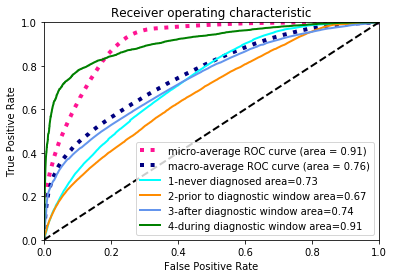

{0: 0.7304026725712804, 1: 0.6748915659170581, 2: 0.7413228863217882, 3: 0.9077133173702476, 'macro': 0.763582641349192, 'micro': 0.9081009861084988}
168


In [11]:
print(evaluate(y_true_cum, y_pred_cum))
print(len(study_rocuac))